In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import random

import torch_geometric.utils

import torch

import seaborn as sns
import pickle

from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle


RDKit WARNING: [11:52:02] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
#Load NetICS network

with open("./data/network/NetICS_Wu_2010.pkl","rb" ) as f:
    netics = pickle.load(f)
netics_adj = netics['adj'].toarray()
netics_node = netics['network_genes']
#netics_node

In [3]:
def check_symmetric(a, tol = 1e-8):
    return np.all(np.abs(a-a.transpose())<tol)

In [17]:
check_symmetric(netics_adj)

False

In [18]:
print(len(netics['network_genes']))
print(netics['adj'].shape)

6016
(6016, 6016)


In [3]:
netics_node_mapping =  dict(zip(np.sort(netics_node),list(range(len(netics_node)))))

len(netics_node_mapping)

6016

In [4]:
with open('netics_node_mapping.pkl','wb') as f:
    pickle.dump(netics_node_mapping,f)

In [5]:
#adj to directed graph

G = nx.DiGraph()
G = nx.from_numpy_matrix(netics_adj, create_using =G )
#G_origin = G_origin.to_directed()
G_trans = nx.DiGraph.reverse(G)


In [6]:
#Load exp data

exp_df = pd.read_pickle("./data/exp/tcga_brca_mRNAseq_RSEM_normalized_log2_plus1_preprocessed.pkl")
gene_list = exp_df.index.tolist()
sample_list = exp_df.columns.tolist()
exp_df
#gene_list

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
A1BG,7.630010,7.897146,8.728725,7.585096,8.076179,7.677873,7.729932,8.300051,5.649592,7.162871,...,5.496785,8.335280,10.012705,9.060797,6.916604,8.883514,7.808774,8.000758,8.783137,7.961896
A1CF,0.000000,0.000000,0.931002,0.000000,0.511468,0.000000,0.000000,0.606916,0.000000,0.000000,...,0.484602,0.000000,0.000000,0.560324,0.000000,0.000000,0.000000,1.749234,0.000000,0.000000
A2BP1,0.000000,0.000000,0.000000,0.000000,2.271963,0.665938,0.000000,0.606916,2.460743,0.412294,...,0.000000,0.000000,0.692249,2.637077,2.519013,0.000000,0.478920,1.273277,0.675635,0.000000
A2LD1,6.699932,6.167209,7.342165,5.988848,7.279566,6.814235,6.686112,7.874177,5.281557,6.084553,...,7.568796,7.820780,6.979354,5.923986,8.290288,5.971102,7.046887,6.338587,6.362838,4.710757
A2ML1,1.250113,2.419593,0.000000,1.408658,2.138913,1.119821,2.343408,0.000000,2.054328,3.105846,...,7.177123,0.000000,4.088464,1.277271,0.000000,2.909965,0.478920,5.826276,1.760987,2.371754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,11.776535,12.426690,12.414619,12.474809,11.981104,12.012968,12.109535,11.654080,12.595195,11.797934,...,12.023927,12.449940,12.656059,12.438674,12.704956,13.417072,12.321677,12.419582,12.704904,11.732813
ZZEF1,10.888693,10.365941,9.882464,9.611271,9.702025,9.850389,10.464110,10.124202,10.916102,10.321892,...,10.280054,9.075079,9.548103,9.923476,9.127632,9.646832,10.918012,10.490261,9.561121,9.143177
ZZZ3,10.206351,8.671516,8.995822,9.455058,9.785783,10.053572,9.154482,8.787575,10.489043,10.224725,...,8.283531,8.597667,8.250810,9.768030,8.170257,8.794698,9.390338,9.898916,9.554260,8.855224
psiTPTE22,1.445356,9.857344,5.184205,6.079197,7.556383,6.427212,5.879331,2.220670,9.111956,6.443182,...,3.558145,3.041926,8.169826,7.789327,4.877312,9.503634,6.635540,7.884100,7.906453,4.451449


In [8]:
exp_df_bf = pd.read_pickle("./data/exp/tcga_brca_mRNAseq_RSEM_normalized_log2_preprocessed.pkl")
gene_list_bf = exp_df_bf.index.tolist()
sample_list_bf = exp_df_bf.columns.tolist()
exp_df_bf

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
A1BG,7.622709,7.891081,8.725321,7.577563,8.070823,7.670811,7.723120,8.295466,5.620563,7.152768,...,5.464476,8.330807,10.011307,9.058093,6.904613,8.880456,7.802326,7.995115,8.779859,7.956098
A2BP1,0.000000,0.000000,0.000000,0.000000,1.937269,-0.769551,0.000000,-0.935117,2.171527,-1.595969,...,0.000000,0.000000,-0.699466,2.384243,2.242420,0.000000,-1.344831,0.502942,-0.743472,0.000000
A2LD1,6.685988,6.146993,7.333247,5.965950,7.270250,6.801358,6.672033,7.868015,5.243981,6.063136,...,7.561177,7.814384,6.967875,5.900026,8.285672,5.947919,7.035935,6.320649,6.345201,4.654584
A2ML1,0.463204,2.121082,0.000000,0.726744,1.767358,0.230449,2.026800,0.000000,1.656954,2.927707,...,7.167120,0.000000,4.001064,0.509747,0.000000,2.703987,-1.344831,5.800623,1.256588,2.062018
A2M,12.501433,12.886455,13.109896,13.419989,13.226629,13.590040,13.911263,11.635938,14.948867,14.538279,...,12.181168,11.785606,12.975046,14.161525,13.225956,12.401229,14.312653,14.061273,15.168928,12.841401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,10.238851,9.237422,9.055784,9.246419,9.599438,9.291136,9.004073,8.329360,10.414229,9.761690,...,8.920820,9.127567,8.572085,9.060519,7.857118,8.300173,9.426661,9.544600,8.982789,9.163566
ZYX,11.776124,12.426428,12.414355,12.474556,11.980747,12.012619,12.109208,11.653632,12.594962,11.797529,...,12.023580,12.449682,12.655835,12.438414,12.704740,13.416940,12.321395,12.419318,12.704688,11.732389
ZZEF1,10.887932,10.364848,9.880935,9.609426,9.700292,9.848825,10.463088,10.122909,10.915356,10.320764,...,10.278893,9.072401,9.546174,9.921989,9.125051,9.645031,10.917266,10.489257,9.559210,9.140624
ZZZ3,10.205129,8.667973,8.992994,9.453001,9.784147,10.052214,9.151948,8.784306,10.488039,10.223519,...,8.278894,8.593938,8.246066,9.766374,8.165240,8.791446,9.388187,9.897404,9.552340,8.852105


In [9]:
#unique gene들이 추가 
len(list(set(gene_list)-set(gene_list_bf)))

2201

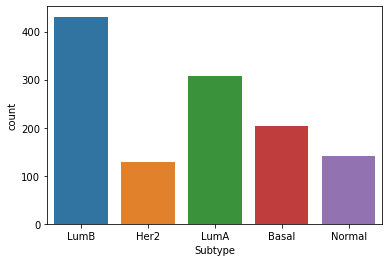

In [10]:
#Load label dict

label_mapping = {"LumA":0 , "LumB":1 , "Her2":2, "Basal":3, "Normal":4}
label_num = len(label_mapping)
label_df = pd.read_csv("./data/exp/tcga_brca_pam50_refine.csv",index_col=0)
sns.countplot(x='Subtype', data=label_df)
label_df['Subtype_index'] = list(map(lambda x:label_mapping[x],label_df['Subtype']))
label_dict = dict(zip(label_df.index, label_df['Subtype_index']))
#label_num
#label_dict
#label_df

In [11]:
#filter exp genes with network nodes
intersection = list(set(netics_node) & (set(gene_list)))
exp_df = exp_df.loc[intersection,:]
exp_df.index = list(map(lambda x:netics_node_mapping[x], exp_df.index))

In [12]:
len(intersection)

5654

In [13]:
binpart=list(set(list(range(0,6016)))-set((exp_df.index.to_list())))

In [14]:
exp_df

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
239,9.139993,9.652303,9.207523,10.953320,10.790868,11.645840,11.659507,11.511978,11.502945,10.160287,...,9.777574,10.529279,10.749060,11.605852,12.131219,11.409714,11.305896,10.736608,10.839971,11.687718
5032,2.454334,2.803537,2.877018,5.362203,6.576947,4.261869,3.535418,5.040182,8.852727,6.863663,...,5.889634,2.763135,1.158143,6.343564,3.017530,2.744484,3.765365,4.010395,8.353745,3.377873
4567,9.471600,10.320039,10.209609,10.113409,10.254853,10.025428,10.110248,10.274317,10.407650,10.736181,...,9.779541,9.885707,9.370238,10.104785,9.992018,10.901954,10.124579,10.242788,9.680395,10.094475
2155,7.214455,8.442644,7.881506,8.026945,8.464915,8.776765,9.691030,6.595613,6.502230,7.931660,...,7.726489,6.775293,9.811014,6.879629,9.149835,7.512804,9.237822,9.081776,9.575875,7.921819
5329,2.542308,2.803537,3.775335,1.408658,1.645102,1.742610,1.784504,1.361207,2.054328,3.762487,...,0.484602,0.785425,0.692249,2.111799,0.000000,0.000000,2.787746,3.318317,1.133958,2.371754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2653,7.746101,7.305155,7.285695,8.178770,7.472453,8.402054,7.793425,7.829497,6.413521,7.510107,...,9.407863,5.998270,7.806845,7.392851,7.613200,5.623507,8.627477,10.029823,9.176424,6.798244
4078,17.084473,2.559247,4.950394,3.147470,2.393773,3.735360,3.316870,0.000000,2.679424,3.762487,...,4.773400,5.825694,2.028286,3.391245,2.869694,2.909965,6.459561,4.244118,4.671859,4.644456
1980,12.592757,13.341445,12.908433,12.540906,12.277776,12.351440,12.447643,12.081710,11.338753,12.082191,...,12.726604,12.916728,13.751937,12.276316,12.843446,12.064618,12.067548,12.270866,12.648979,12.576074
4392,8.677440,11.101161,9.087634,9.615082,8.420811,9.268954,8.544783,4.454209,8.845680,10.655627,...,9.890500,7.612097,9.223390,10.418218,9.354879,10.373070,10.407778,10.981413,9.588243,8.295446


In [15]:
listzero = [0 for i in range(1212)]
for j in binpart:
    exp_df.loc[j]=listzero
exp_df = exp_df.loc[range(len(netics_node)), :]

In [105]:
len(netics_node)

6016

In [106]:
with open('netics_node.pkl','wb') as f:
    pickle.dump(netics_node,f)

In [99]:
exp_df

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12.501682,12.886645,13.110059,13.420121,13.226780,13.590157,13.911357,11.636391,14.948912,14.538340,...,12.181479,11.786015,12.975225,14.161604,13.226107,12.401495,14.312724,14.061357,15.168967,12.841598
2,9.345044,9.796011,9.500805,9.603619,9.679742,9.899949,9.630014,9.772201,9.477337,9.045308,...,10.626372,8.983179,10.477807,10.205063,10.372779,10.307821,9.467782,9.818179,10.028617,9.772188
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,10.569772,12.901294,11.035428,10.904020,10.362294,10.174936,10.292855,10.900933,9.846231,10.373893,...,10.375926,9.941978,10.875037,9.961057,11.258412,9.940270,10.117439,9.508675,10.677939,10.300382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,8.754298,8.415329,8.255613,8.299326,8.223385,8.604837,8.936631,8.666525,9.266632,8.525701,...,8.425982,9.664305,8.666121,8.334427,7.873066,8.436075,8.409291,8.472792,8.430683,8.426708
6012,8.703295,10.182800,8.259374,8.627554,8.667859,8.372253,8.076890,8.814639,8.894106,8.544754,...,8.993013,8.547045,7.337476,7.831782,7.479334,7.238541,8.836199,9.053107,7.443844,9.028374
6013,9.865668,9.916176,11.306220,9.387150,9.399744,8.790208,9.071683,10.722197,8.331845,9.343734,...,9.414630,10.622946,7.961059,7.807780,8.950384,7.506356,8.839477,9.441655,8.020362,11.250797
6014,11.776535,12.426690,12.414619,12.474809,11.981104,12.012968,12.109535,11.654080,12.595195,11.797934,...,12.023927,12.449940,12.656059,12.438674,12.704956,13.417072,12.321677,12.419582,12.704904,11.732813


In [17]:
#finding TF nodes for trans propagation

network_file = "./data/network/omnipath/omnipath_webservice_interactions__recent.tsv"
network_df = pd.read_csv(network_file,sep="\t")
network_df= network_df[np.logical_and(network_df['source_genesymbol'].isin(gene_list),network_df['target_genesymbol'].isin(gene_list))]
network_df = network_df[['source_genesymbol','target_genesymbol','type']]
#print(len(network_df['source_genesymbol'].unique()))
#print(len(network_df['target_genesymbol'].unique()))
#print(len(network_df.unique()))
network_df

/home/minjae/miniconda3/envs/minjae/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (12,19,20,21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,source_genesymbol,target_genesymbol,type
0,UBC,VCP,PPI
1,UBC,GRIN1,PPI
2,UBC,TGM2,PPI
3,UBC,ITPR3,PPI
4,UBC,FAF1,PPI
...,...,...,...
236530,MSC,MCM7,TF
236531,STAT2,IRF7,TF
236533,GLI2,ILF3,TF
236535,GLI2,IGFBP3,TF


In [18]:
PPI_source = list(set(network_df[network_df['type']=='PPI']['source_genesymbol'].to_list()))
TF_target = list(set(network_df[network_df['type'] == 'TF']['target_genesymbol'].to_list()))

In [19]:
print(len(TF_target),len(PPI_source))

3582 6828


In [21]:
doublet = list(set(TF_target)&(set(PPI_source)))
len(doublet)

2502

In [22]:
TF_list = list(set(network_df[network_df['type'] == "TF"]['target_genesymbol'].to_list()))
len(TF_list)

3582

In [23]:
TF_intersect = list(set(netics_node) & (set(TF_list)))
len(TF_intersect)

1908

In [24]:
sourcetarget = list(set(doublet)&set(TF_intersect))
len(sourcetarget)

1744

In [25]:
TF_index = []
for i in TF_intersect:
    TF_index.append(netics_node_mapping.get(i))
len(TF_index)

1908

In [26]:
#finding protein nodes for original propagation

patient_list = exp_df.columns.to_list()
mut_none = []
mut_gene = {}
uni_mut = []
for i in patient_list :
    try:
        mutation =  pd.read_csv('./data/mutation/{}.maf.txt'.format(i), sep = "\t") 
        mut_intersect = list((set(mutation["Hugo_Symbol"].to_list())) & (set(netics_node)))
        mut_intersect = list(set(mut_intersect)-set(TF_intersect))
        mut_index = []
        uni_mut.extend(mut_intersect)
        for j in mut_intersect:
            mut_index.append(netics_node_mapping.get(j))
        mut_gene[i] = mut_index
    except:
        mut_none.append(i)
print(len(mut_gene))
print(len(mut_none))

979
233


In [27]:
mut_gene.get('TCGA-A1-A0SB-01')

[14, 3179, 3587, 5225]

In [28]:
uni_mut_gene = list(set(uni_mut))

In [29]:
stm = list(set(sourcetarget)&set(uni_mut_gene))
len(stm)

0

In [100]:
exp_sample=exp_df.drop(mut_none, axis =1)

In [101]:
exp_sample

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,14.948912,14.538340,13.941184,13.927870,13.606635,13.773022,13.261198,14.432732,12.033201,13.129526,...,13.953547,11.877640,13.777746,13.426439,15.344069,13.786688,12.865303,13.704505,13.890768,13.920723
2,9.477337,9.045308,9.316159,9.975079,9.491707,9.036263,9.285433,8.988673,9.988866,8.686447,...,9.056910,9.584496,9.247375,9.681707,9.041171,9.781728,9.315610,10.155043,10.292873,9.702751
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,9.846231,10.373893,10.539918,10.523277,9.914519,10.355547,9.555211,10.909893,10.744385,10.292139,...,9.822872,9.682047,11.723473,10.554511,10.244237,10.060286,10.755296,10.924270,9.936822,9.949514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,9.266632,8.525701,8.527142,8.954878,8.933115,8.241089,9.551255,8.554369,10.799253,8.276254,...,8.700033,8.431479,8.495470,8.621420,9.071702,8.007990,8.833151,8.342697,8.070886,8.758744
6012,8.894106,8.544754,8.789664,8.066679,8.345444,8.655343,8.279951,8.475020,10.166047,8.968249,...,8.574323,9.260273,9.168081,8.301856,8.779561,8.423698,8.122525,8.792505,8.138172,8.587173
6013,8.331845,9.343734,9.665087,9.404881,9.139668,8.440227,10.720237,8.719962,10.728126,8.983138,...,9.691199,10.238597,10.258777,9.070650,8.915889,8.864416,8.092170,10.405228,9.803557,9.063034
6014,12.595195,11.797934,11.554980,12.383833,11.512063,12.416260,12.140927,11.566577,9.210035,12.158318,...,12.432412,11.903573,12.967609,12.023917,12.693090,12.349216,12.276868,12.126246,11.781517,12.154033


In [103]:
with open('netics_ori_exp.pkl','wb') as f:
    pickle.dump(exp_sample,f)

In [65]:
exp_TF = exp_df.drop(mut_none, axis =1)

In [32]:
exp_sample.loc[range(6016)]=0

In [33]:
for i in mut_gene.keys():
    exp_sample.loc[mut_gene.get(i),i]=1
exp_sample

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
exp_TF.loc[list(set(range(6016))-set(TF_index))] = 0

In [90]:
exp_TF

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,14.948912,14.538340,13.941184,13.927870,13.606635,13.773022,13.261198,14.432732,12.033201,13.129526,...,13.953547,11.877640,13.777746,13.426439,15.344069,13.786688,12.865303,13.704505,13.890768,13.920723
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,9.266632,8.525701,8.527142,8.954878,8.933115,8.241089,9.551255,8.554369,10.799253,8.276254,...,8.700033,8.431479,8.495470,8.621420,9.071702,8.007990,8.833151,8.342697,8.070886,8.758744
6012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [121]:
exp_TF_sorted = pd.DataFrame(np.sort(exp_TF.values, axis=0), index = exp_TF.index, columns = exp_TF.columns)

In [41]:
exp_TF_sorted

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,16.655411,16.201148,16.415411,16.530784,16.614689,18.258089,17.681815,16.060414,15.713168,17.559876,...,16.717823,16.137163,16.256789,16.078317,16.652902,16.274874,16.525256,15.803594,16.757918,16.618169
6012,16.669372,16.286137,16.596228,16.534246,16.850153,19.148909,18.822199,16.156570,15.764442,17.612126,...,16.907079,16.610846,16.349343,16.154672,16.802493,16.285559,16.584527,15.921646,16.774080,16.760968
6013,16.834002,16.398978,17.370514,16.549585,16.959513,19.475273,18.831291,16.175546,15.781318,17.736986,...,17.019639,17.719205,16.434609,16.171301,16.965047,16.474288,17.063033,15.977064,16.975995,16.821832
6014,16.940636,16.663689,17.479469,16.948123,17.291880,19.648268,18.910762,16.286041,16.424504,17.820983,...,17.020508,17.727862,16.539896,16.483491,17.171610,16.512642,17.314051,16.266835,17.190357,16.895935


In [64]:
exp_TF_mean = exp_TF_sorted.mean(axis =1)

NameError: name 'exp_TF_sorted' is not defined

In [46]:
exp_TF_mean.index = np.arange(1,len(exp_TF_mean)+1)
exp_TF_mean

1        0.000000
2        0.000000
3        0.000000
4        0.000000
5        0.000000
          ...    
6012    16.412454
6013    16.634832
6014    16.831377
6015    17.053290
6016    17.467255
Length: 6016, dtype: float64

In [52]:
exp_TF.rank(method='min').astype(int)

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,5990,5991,5966,5957,5953,5944,5917,5987,5805,5889,...,5949,5794,5930,5940,5996,5949,5886,5944,5968,5965
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,5147,4906,4946,5022,5066,4898,5140,4917,5545,4893,...,4892,5027,4923,4983,4962,4838,5026,4914,4845,4938
6012,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6013,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6014,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [53]:
exp_TF_qn = exp_TF.rank(method='min').stack().astype(int).map(exp_TF_mean).unstack()

In [54]:
exp_TF_qn

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,14.628881,14.667158,13.97773,13.806472,13.737845,13.595358,13.218486,14.517536,12.147924,12.890141,...,13.671949,12.065679,13.390813,13.534935,14.886107,13.671949,12.858070,13.595358,14.019068,13.956624
2,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,9.368549,8.313546,8.50597,8.849859,9.037634,8.274147,9.341696,8.367402,10.783429,8.249290,...,8.244291,8.871837,8.396555,8.676055,8.579951,7.960274,8.867593,8.353043,7.998213,8.468584
6012,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6013,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6014,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [91]:
exp_TF_norm = exp_TF.div(exp_TF.sum(axis=1), axis=0).fillna(0)

In [92]:
std = exp_TF.std(axis=1)

In [93]:
mean = exp_TF.mean(axis=1) 

In [94]:
exp_TF_z = (exp_TF.T - mean) / std

In [95]:
exp_TF_z=exp_TF_z.fillna(0).T 

In [96]:
exp_TF_z

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.499840,1.083664,0.478357,0.464861,0.139242,0.307900,-0.210910,0.976614,-1.455666,-0.344379,...,0.490889,-1.613351,0.312689,-0.043413,1.900389,0.321752,-0.612208,0.238448,0.427253,0.457617
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.686628,-0.615321,-0.612789,0.138820,0.100578,-1.115437,1.186762,-0.564946,3.379720,-1.053646,...,-0.308989,-0.780887,-0.668443,-0.447127,0.344100,-1.525033,-0.075077,-0.936894,-1.414514,-0.205823
6012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [97]:
with open("pagerank_exp_data.pkl",'wb') as f:
    pickle.dump(exp_TF_z,f)

In [75]:
exp_TF_z = torch.tensor(exp_TF_z.values,dtype=torch.float)

In [76]:
exp_TF_z.dtype

torch.float32

In [42]:
with open('./data/preprocessed/netics_adj_trans_norm_sp.pkl', 'rb') as f:
    netics_adj_trans_norm = pickle.load(f)

In [43]:
netics_adj_trans_norm.shape

torch.Size([6016, 6016])

In [78]:
h_TF = exp_TF_z
for k in range(10):
    print(k)
    x_TF = exp_TF_z*(1-0.1)
    x_TF = torch.sparse.mm(netics_adj_trans_norm,x_TF)
x_TF +=h_TF*0.1

0
1
2
3
4
5
6
7
8
9


In [88]:
with open("pagerank_exp_data.pkl",'wb') as f:
    pickle.dump(x_TF,f)

In [255]:
exp_TF_z.sum(axis =1)

0       0.000000e+00
1       1.280753e-12
2       0.000000e+00
3       0.000000e+00
4       0.000000e+00
            ...     
6011   -8.277823e-13
6012    0.000000e+00
6013    0.000000e+00
6014    0.000000e+00
6015    0.000000e+00
Length: 6016, dtype: float64

In [129]:
for i in range(6016):
    for j in range(979):
        if exp_TF_z.iloc[i,j] >= 1.645 or exp_TF_z.iloc[i,j] <= -1.645:
            exp_TF_z.iloc[i,j] = 1
        else:
            exp_TF_z.iloc[i,j] = 0
        

In [130]:
exp_TF_z

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
#Torch Dataset 
#exp_sample for mut_gene per patients, G
#exp_TF for TF of all patients, G_trans

patients_list = exp_sample.columns.tolist()
patients_shuffled_list = shuffle(patients_list, random_state=1)

In [80]:
G_edgeindex = []
for e1,e2 in G.edges:
    G_edgeindex.append([e1,e2])
G_edgeindex = torch.tensor(G_edgeindex).t().contiguous()
print(G_edgeindex[1])

tensor([1303, 1971,  429,  ..., 5391, 5908, 5964])


In [81]:
G_trans_edgeindex = []
for e1,e2 in G_trans.edges:
    G_trans_edgeindex.append([e1,e2])
G_trans_edgeindex = torch.tensor(G_trans_edgeindex).t().contiguous()
print(G_trans_edgeindex[1])

tensor([ 100,  273,  589,  ..., 5382, 5908, 5964])


In [82]:
datalist_sample = []
datalist_TF = []
for patients in patients_shuffled_list:
    #exp_sample
    patients_exp_sample = exp_sample[patients]
    patients_exp_sample = patients_exp_sample.values
    
    x_sample = torch.tensor(patients_exp_sample,dtype=torch.float)
    x_sample = torch.unsqueeze(x_sample,1)
    
    #exp_TF
    patients_exp_TF = exp_TF[patients]
    patients_exp_TF = patients_exp_TF.values
    x_TF = torch.tensor(patients_exp_TF,dtype=torch.float)
    x_TF = torch.unsqueeze(x_TF,1)
    
    y = torch.LongTensor([label_dict[patients]])
    
    GNNData_sample = Data(x=x_sample,edge_index=G_edgeindex,y=y)
    GNNData_TF = Data(x=x_TF,edge_index=G_trans_edgeindex, y=y)
    
    datalist_sample.append(GNNData_sample)
    datalist_TF.append(GNNData_TF)    

In [256]:
#datalist_sample = []
datalist_TF_z = []
for patients in patients_shuffled_list:
    #exp_sample
    #patients_exp_sample = exp_sample[patients]
    #patients_exp_sample = patients_exp_sample.values
    
    #x_sample = torch.tensor(patients_exp_sample,dtype=torch.float)
    #x_sample = torch.unsqueeze(x_sample,1)
    
    #exp_TF
    patients_exp_TF_z = exp_TF_z[patients]
    patients_exp_TF_z = patients_exp_TF_z.values
    x_TF_z = torch.tensor(patients_exp_TF_z,dtype=torch.float)
    x_TF_z = torch.unsqueeze(x_TF_z,1)
    
    y = torch.LongTensor([label_dict[patients]])
    
    #GNNData_sample = Data(x=x_sample,edge_index=G_edgeindex,y=y)
    GNNData_TF_z = Data(x=x_TF_z,edge_index=G_trans_edgeindex, y=y)
    
    #datalist_sample.append(GNNData_sample)
    datalist_TF_z.append(GNNData_TF_z) 

In [132]:
datalist_TF_znorm = []
for patients in patients_shuffled_list:
    #exp_sample
    #patients_exp_sample = exp_sample[patients]
    #patients_exp_sample = patients_exp_sample.values
    
    #x_sample = torch.tensor(patients_exp_sample,dtype=torch.float)
    #x_sample = torch.unsqueeze(x_sample,1)
    
    #exp_TF
    patients_exp_TF_znorm = exp_TF_z[patients]
    patients_exp_TF_znorm = patients_exp_TF_znorm.values
    x_TF_znorm = torch.tensor(patients_exp_TF_znorm,dtype=torch.float)
    x_TF_znorm = torch.unsqueeze(x_TF_znorm,1)
    
    y = torch.LongTensor([label_dict[patients]])
    
    #GNNData_sample = Data(x=x_sample,edge_index=G_edgeindex,y=y)
    GNNData_TF_znorm = Data(x=x_TF_znorm,edge_index=G_trans_edgeindex, y=y)
    
    #datalist_sample.append(GNNData_sample)
    datalist_TF_znorm.append(GNNData_TF_znorm) 

In [85]:
#datalist_sample = []
datalist_TF_qn = []
for patients in patients_shuffled_list:
    #exp_sample
    #patients_exp_sample = exp_sample[patients]
    #patients_exp_sample = patients_exp_sample.values
    
    #x_sample = torch.tensor(patients_exp_sample,dtype=torch.float)
    #x_sample = torch.unsqueeze(x_sample,1)
    
    #exp_TF
    patients_exp_TF_qn = exp_TF_qn[patients]
    patients_exp_TF_qn = patients_exp_TF_qn.values
    x_TF_qn = torch.tensor(patients_exp_TF_qn,dtype=torch.float)
    x_TF_qn = torch.unsqueeze(x_TF_qn,1)
    
    y = torch.LongTensor([label_dict[patients]])
    
    #GNNData_sample = Data(x=x_sample,edge_index=G_edgeindex,y=y)
    GNNData_TF_qn = Data(x=x_TF_qn,edge_index=G_trans_edgeindex, y=y)
    
    #datalist_sample.append(GNNData_sample)
    datalist_TF_qn.append(GNNData_TF_qn) 

In [86]:
#Make CV dataset and Save

kf = KFold(n_splits=10,shuffle=False)
train_index_sample = []
test_index_sample = []
train_index_TF = []
test_index_TF = []


for train_index, test_index in kf.split(range(len(datalist_sample))):
    train_index_sample.append(train_index)
    test_index_sample.append(test_index)
for train_index, test_index in kf.split(range(len(datalist_TF))):
    train_index_TF.append(train_index)
    test_index_TF.append(test_index)

In [257]:
kf = KFold(n_splits=10,shuffle=False)
train_index_TF_z = []
test_index_TF_z = []

for train_index, test_index in kf.split(range(len(datalist_TF_z))):
    train_index_TF_z.append(train_index)
    test_index_TF_z.append(test_index)

In [133]:
kf = KFold(n_splits=10,shuffle=False)
train_index_TF_znorm = []
test_index_TF_znorm = []

for train_index, test_index in kf.split(range(len(datalist_TF_znorm))):
    train_index_TF_znorm.append(train_index)
    test_index_TF_znorm.append(test_index)

In [88]:
kf = KFold(n_splits=10,shuffle=False)
train_index_TF_qn = []
test_index_TF_qn = []

for train_index, test_index in kf.split(range(len(datalist_TF_qn))):
    train_index_TF_qn.append(train_index)
    test_index_TF_qn.append(test_index)

In [89]:
#Not shuffle
i = 0
for train_index, test_index in zip(train_index_sample,test_index_sample):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(datalist_sample[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(datalist_sample[test_idx])
        
    f = open("./data/preprocessed/cv/netics_exp_sample_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/netics_exp_sample_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

In [90]:
i = 0
for train_index, test_index in zip(train_index_TF,test_index_TF):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(datalist_TF[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(datalist_TF[test_idx])
        
    f = open("./data/preprocessed/cv/netics_exp_TF_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/netics_exp_TF_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

In [258]:
i = 0
for train_index, test_index in zip(train_index_TF_z,test_index_TF_z):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(datalist_TF_z[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(datalist_TF_z[test_idx])
        
    f = open("./data/preprocessed/cv/netics_exp_TF_z_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/netics_exp_TF_z_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

In [134]:
i = 0
for train_index, test_index in zip(train_index_TF_znorm,test_index_TF_znorm):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(datalist_TF_znorm[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(datalist_TF_znorm[test_idx])
        
    f = open("./data/preprocessed/cv/netics_exp_TF_znorm_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/netics_exp_TF_znorm_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

In [92]:
i = 0
for train_index, test_index in zip(train_index_TF_qn,test_index_TF_qn):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(datalist_TF_qn[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(datalist_TF_qn[test_idx])
        
    f = open("./data/preprocessed/cv/netics_exp_TF_qn_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/netics_exp_TF_qn_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

In [93]:
#save

f = open("./data/preprocessed/netics_G_edgeindex.pkl",'wb')
pickle.dump(G_edgeindex, f)
f.close()

f = open("./data/preprocessed/netics_G_trans_edgeindex.pkl",'wb')
pickle.dump(G_trans_edgeindex, f)
f.close()

In [94]:
G_un = G.to_undirected()

In [95]:
G_un_edgeindex = []
for e1,e2 in G_un.edges:
    G_un_edgeindex.append([e1,e2])
G_un_edgeindex = torch.tensor(G_un_edgeindex).t().contiguous()
print(G_un_edgeindex[1])

tensor([1303, 1971,  100,  ..., 6012, 6013, 6013])


In [96]:
f = open("./data/preprocessed/netics_G_un_edgeindex.pkl",'wb')
pickle.dump(G_un_edgeindex, f)
f.close()

In [97]:
netics_adj.dtype

dtype('uint8')

In [98]:
rowsum = np.array(netics_adj.sum(1))

In [99]:
r_inv = np.power(rowsum, -1).flatten()

In [100]:
r_inv

array([0.5       , 0.1       , 0.03571429, ..., 0.01176471, 0.05555556,
       0.08333333])

In [101]:
r_inv[np.isinf(r_inv)] =0.

In [102]:
r_mat_inv = np.diag(r_inv)

In [103]:
r_mat_inv

array([[0.5       , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03571429, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.01176471, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05555556,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08333333]])

In [104]:
#r_mat_inv.shape
netics_adj.shape

(6016, 6016)

In [105]:
netics_adj_norm = np.matmul(netics_adj, r_mat_inv)

In [106]:
netics_adj_norm1 = netics_adj.dot(r_mat_inv)

In [107]:
netics_adj_norm = torch.Tensor(netics_adj_norm)

In [108]:
netics_adj_norm.dtype

torch.float32

In [109]:
f = open("./data/preprocessed/netics_adj_norm.pkl",'wb')
pickle.dump(netics_adj_norm, f)
f.close()

In [110]:
rowsum1 = np.array(netics_adj.T.sum(1))

In [111]:
r_inv1 = np.power(rowsum1, -1).flatten()

In [112]:
r_inv1[np.isinf(r_inv1)] =0.

In [113]:
r_mat_inv1 = np.diag(r_inv1)

In [114]:
netics_adj_trans_norm = netics_adj.T.dot(r_mat_inv1)

In [115]:
netics_adj_trans_norm = torch.Tensor(netics_adj_trans_norm)

In [116]:
np.array_equal(netics_adj_trans_norm,netics_adj_norm)

False

In [117]:
f = open("./data/preprocessed/netics_adj_trans_norm.pkl",'wb')
pickle.dump(netics_adj_trans_norm, f)
f.close()

In [140]:
adj_norm = netics_adj_norm.numpy()

In [141]:
adj_trans_norm = netics_adj_trans_norm.numpy()

In [180]:
G_edgeindex[1]

tensor([1303, 1971,  429,  ..., 5391, 5908, 5964])

In [185]:
G_trans_edgeindex[1]

tensor([ 100,  273,  589,  ..., 5382, 5908, 5964])

In [204]:
value = []
for i in range(6016*6016):
    if adj_norm.item(i) != 0.:
        value.append(adj_norm.item(i))
print(len(value))

193216


In [203]:
value_trans = []
for i in range(6016*6016):
    if adj_trans_norm.item(i) != 0.:
        value_trans.append(adj_trans_norm.item(i))
print(len(value_trans))

193216


In [206]:
i = torch.LongTensor(G_edgeindex)
v = torch.FloatTensor(value)
adj_norm_sp = torch.sparse.FloatTensor(i,v)
i_trans = torch.LongTensor(G_trans_edgeindex)
v_trans = torch.FloatTensor(value_trans)
adj_trans_norm_sp = torch.sparse.FloatTensor(i_trans,v_trans)

In [200]:
len(G_edgeindex[0])

193216

In [202]:
len(value_trans)

193216

In [207]:
adj_norm_sp

tensor(indices=tensor([[   0,    0,    1,  ..., 6015, 6015, 6015],
                       [1303, 1971,  429,  ..., 5391, 5908, 5964]]),
       values=tensor([0.0024, 0.0145, 0.1250,  ..., 0.0345, 0.0345, 0.1000]),
       size=(6016, 6016), nnz=193216, layout=torch.sparse_coo)

In [208]:
adj_trans_norm_sp

tensor(indices=tensor([[   0,    0,    1,  ..., 6015, 6015, 6015],
                       [ 100,  273,  589,  ..., 5382, 5908, 5964]]),
       values=tensor([0.2000, 0.0058, 0.0312,  ..., 0.0370, 0.0357, 0.1000]),
       size=(6016, 6016), nnz=193216, layout=torch.sparse_coo)

In [209]:
f = open("./data/preprocessed/netics_adj_norm_sp.pkl",'wb')
pickle.dump(adj_norm_sp, f)
f.close()

In [4]:
with open("./data/preprocessed/netics_adj_norm_sp.pkl",'rb') as f:
    sparse = pickle.load(f)

In [13]:
s_ori_v=sparse._values()
s_ori_v[0] = 0.
s_ori_v
i = sparse._indices()
change=torch.sparse.FloatTensor(i,s_ori_v)
change._values()

tensor([0.0000, 0.0145, 0.1250,  ..., 0.0345, 0.0345, 0.1000])

In [210]:
f = open("./data/preprocessed/netics_adj_trans_norm_sp.pkl",'wb')
pickle.dump(adj_trans_norm_sp, f)
f.close()

In [4]:
origin_exp_df = pd.read_pickle("./data/exp/tcga_brca_mRNAseq_RSEM_normalized_log2_plus1_preprocessed.pkl")
origin_gene_list = origin_exp_df.index.tolist()
origin_sample_list = origin_exp_df.columns.tolist()
origin_exp_df
#gene_list

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
A1BG,7.630010,7.897146,8.728725,7.585096,8.076179,7.677873,7.729932,8.300051,5.649592,7.162871,...,5.496785,8.335280,10.012705,9.060797,6.916604,8.883514,7.808774,8.000758,8.783137,7.961896
A1CF,0.000000,0.000000,0.931002,0.000000,0.511468,0.000000,0.000000,0.606916,0.000000,0.000000,...,0.484602,0.000000,0.000000,0.560324,0.000000,0.000000,0.000000,1.749234,0.000000,0.000000
A2BP1,0.000000,0.000000,0.000000,0.000000,2.271963,0.665938,0.000000,0.606916,2.460743,0.412294,...,0.000000,0.000000,0.692249,2.637077,2.519013,0.000000,0.478920,1.273277,0.675635,0.000000
A2LD1,6.699932,6.167209,7.342165,5.988848,7.279566,6.814235,6.686112,7.874177,5.281557,6.084553,...,7.568796,7.820780,6.979354,5.923986,8.290288,5.971102,7.046887,6.338587,6.362838,4.710757
A2ML1,1.250113,2.419593,0.000000,1.408658,2.138913,1.119821,2.343408,0.000000,2.054328,3.105846,...,7.177123,0.000000,4.088464,1.277271,0.000000,2.909965,0.478920,5.826276,1.760987,2.371754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,11.776535,12.426690,12.414619,12.474809,11.981104,12.012968,12.109535,11.654080,12.595195,11.797934,...,12.023927,12.449940,12.656059,12.438674,12.704956,13.417072,12.321677,12.419582,12.704904,11.732813
ZZEF1,10.888693,10.365941,9.882464,9.611271,9.702025,9.850389,10.464110,10.124202,10.916102,10.321892,...,10.280054,9.075079,9.548103,9.923476,9.127632,9.646832,10.918012,10.490261,9.561121,9.143177
ZZZ3,10.206351,8.671516,8.995822,9.455058,9.785783,10.053572,9.154482,8.787575,10.489043,10.224725,...,8.283531,8.597667,8.250810,9.768030,8.170257,8.794698,9.390338,9.898916,9.554260,8.855224
psiTPTE22,1.445356,9.857344,5.184205,6.079197,7.556383,6.427212,5.879331,2.220670,9.111956,6.443182,...,3.558145,3.041926,8.169826,7.789327,4.877312,9.503634,6.635540,7.884100,7.906453,4.451449


In [6]:
originexp_df=origin_exp_df.drop(mut_none, axis =1)

NameError: name 'mut_none' is not defined

In [235]:
oripatient_list = originexp_df.columns.to_list()
ifmut_none = []
orimut_gene = {}

for i in oripatient_list :
    try:
        mutation =  pd.read_csv('./data/mutation/{}.maf.txt'.format(i), sep = "\t") 
        mut_intersect = list((set(mutation["Hugo_Symbol"].to_list())) & (set(origin_gene_list)))
        mut_intersect = list(set(mut_intersect)-set(TF_list))
        orimut_gene[i] = mut_intersect
    except:
        ifmut_none.append(i)
print(len(orimut_gene))
print(len(ifmut_none))

979
0


In [236]:
oriexp_df = originexp_df
oriexp_mut = originexp_df

In [237]:
oriexp_mut.loc[range(20502)]=0
oriexp_mut

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2BP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2LD1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZEF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZZ3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
psiTPTE22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [238]:
for i in orimut_gene.keys():
    oriexp_mut.loc[orimut_gene.get(i),i]=1
oriexp_mut

,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,TCGA-A1-A0SE-01,TCGA-A1-A0SF-01,TCGA-A1-A0SG-01,TCGA-A1-A0SH-01,TCGA-A1-A0SI-01,TCGA-A1-A0SJ-01,TCGA-A1-A0SK-01,TCGA-A1-A0SM-01,...,TCGA-OL-A5RY-01,TCGA-OL-A5RZ-01,TCGA-OL-A5S0-01,TCGA-OL-A66H-01,TCGA-OL-A66I-01,TCGA-OL-A66J-01,TCGA-OL-A66K-01,TCGA-PE-A5DC-01,TCGA-PE-A5DD-01,TCGA-PE-A5DE-01
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2BP1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2LD1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2ML1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZEF1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZZZ3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
psiTPTE22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
oripatients_list = oriexp_mut.columns.tolist()
oripatients_shuffled_list = shuffle(oripatients_list, random_state=1)

In [242]:
datalist_oriexp = []
datalist_orimut = []
for patients in oripatients_shuffled_list:
    #exp_sample
    patients_exp_sample = oriexp_mut[patients]
    patients_exp_sample = patients_exp_sample.values
    
    x_mut = torch.tensor(patients_exp_sample,dtype=torch.float)
    x_mut = torch.unsqueeze(x_mut,1)
    
    #exp_TF
    patients_exp_TF = oriexp_df[patients]
    patients_exp_TF = patients_exp_TF.values
    x_df = torch.tensor(patients_exp_TF,dtype=torch.float)
    x_df = torch.unsqueeze(x_df,1)
    
    y = torch.LongTensor([label_dict[patients]])
    
    GNNData_mut = Data(x=x_mut,y=y)
    GNNData_df = Data(x=x_df, y=y)
    
    datalist_orimut.append(GNNData_mut)
    datalist_oriexp.append(GNNData_df)   

In [243]:

kf = KFold(n_splits=10,shuffle=False)
train_index_sample = []
test_index_sample = []
train_index_TF = []
test_index_TF = []


for train_index, test_index in kf.split(range(len(datalist_orimut))):
    train_index_sample.append(train_index)
    test_index_sample.append(test_index)
for train_index, test_index in kf.split(range(len(datalist_oriexp))):
    train_index_TF.append(train_index)
    test_index_TF.append(test_index)

In [245]:
#Not shuffle
i = 0
for train_index, test_index in zip(train_index_sample,test_index_sample):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(datalist_orimut[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(datalist_orimut[test_idx])
        
    f = open("./data/preprocessed/cv/exp_orimut_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/exp_orimut_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1

In [244]:
#Ori Not shuffle
i = 0
for train_index, test_index in zip(train_index_TF,test_index_TF):
    train_data_list = []
    for train_idx in train_index:
        train_data_list.append(datalist_oriexp[train_idx])
    
    test_data_list = []
    for test_idx in test_index:
        test_data_list.append(datalist_oriexp[test_idx])
        
    f = open("./data/preprocessed/cv/exp_oriexp_train_{}.pkl".format(i),'wb')
    pickle.dump(train_data_list, f)
    f.close()

    f = open("./data/preprocessed/cv/exp_oriexp_test_{}.pkl".format(i),'wb')
    pickle.dump(test_data_list, f)
    f.close()
    
    i = i+1